In [1]:
import fiona
import os
from ops.ops import load_json, create_exps_paths, load_exp, load_opt_image
from tqdm.notebook import tqdm_notebook
from osgeo import gdal
from osgeo import gdalconst
import numpy as np
from tensorflow.keras.utils import to_categorical
from skimage.morphology import area_opening
from matplotlib import pyplot as plt 
import matplotlib
from sklearn.metrics import f1_score

In [2]:
paths = load_json(os.path.join('conf', 'paths.json'))
shp = load_json(os.path.join('conf', 'shp.json'))
shp_path = paths['shp']
conf = load_json(os.path.join('conf', 'conf.json'))
test_tiles_path = os.path.join('img', 'patches')
img_source = conf['img_source']
grid_shp = shp[f'shp_download_{img_source}']
grid_save = os.path.join('shp', f"{grid_shp}.shp")
cmap_scl_path = os.path.join('img', 'GEE_scl')

In [3]:
with fiona.open(grid_save) as grid:
    cmap_all = None
    #res_opt = None
    for feat in tqdm_notebook(grid, desc = 'Tiles evaluated'):
        if feat['properties']['dataset'] !=2:
            continue
        feat_id = int(feat['properties']['id'])
        cmap_scl_19 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2019.tif'))
        cmap_scl_20 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2020.tif'))
        cmap = np.concatenate([
            np.expand_dims(cmap_scl_19[:,:,1], axis=-1),
            np.expand_dims(cmap_scl_20[:,:,1], axis=-1)
            ], axis=2)
        del cmap_scl_19, cmap_scl_20
        cmap_max = cmap.max(axis=-1)

        #opt_pred_prob = np.load(os.path.join(opt_res_path, 'predictions', f'{feat_id}_fus.npy'))[:,:,1]
        #opt_pred = np.zeros_like(opt_pred_prob, dtype=np.int8)
        #opt_pred[opt_pred_prob>0.5] = 1
        #del opt_pred_prob



        if cmap_all is None:
            cmap_all = cmap_max.flatten()
            #res_opt = opt_pred.flatten()
        else:
            cmap_all = np.concatenate([cmap_all, cmap_max.flatten()], axis=-1)
            #res_opt = np.concatenate([res_opt, res_opt.flatten()], axis=-1)
    cmap_all = cmap_all/100

Tiles evaluated:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
h = np.histogram(cmap_all, bins=[0,0.05,0.7,1])
print(h[0]/cmap_all.shape[0])

[0.74584617 0.07031933 0.1838345 ]


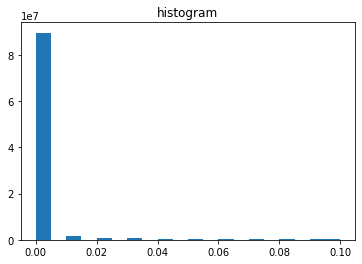

In [5]:
plt.hist(cmap_all, bins=20, range=[0, 0.1]) 
plt.title("histogram") 
plt.show()

In [6]:
min_area = 625

opt_exp = 1
exps_path, exp_path, models_path, results_path, predictions_path, visual_path, logs_path = create_exps_paths(opt_exp)
opt_res_path = results_path

sar_exp = 2
exps_path, exp_path, models_path, results_path, predictions_path, visual_path, logs_path = create_exps_paths(sar_exp)
sar_res_path = results_path

ef_exp = 3
exps_path, exp_path, models_path, results_path, predictions_path, visual_path, logs_path = create_exps_paths(ef_exp)
ef_res_path = results_path

jf_exp = 4
exps_path, exp_path, models_path, results_path, predictions_path, visual_path, logs_path = create_exps_paths(jf_exp)
jf_res_path = results_path

lf_exp = 5
exps_path, exp_path, models_path, results_path, predictions_path, visual_path, logs_path = create_exps_paths(lf_exp)
lf_res_path = results_path

## Optical data

In [7]:
with fiona.open(grid_save) as grid:
    opt_label = []
    opt_cmap = []
    opt_res = []
    for feat in tqdm_notebook(grid, desc = 'Tiles evaluated'):
        if feat['properties']['dataset'] !=2:
            continue
        feat_id = int(feat['properties']['id'])

        cmap_scl_19 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2019.tif'))
        cmap_scl_20 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2020.tif'))
        cmap = np.concatenate([
            np.expand_dims(cmap_scl_19[:,:,1], axis=-1),
            np.expand_dims(cmap_scl_20[:,:,1], axis=-1)
            ], axis=2)
        del cmap_scl_19, cmap_scl_20
        cmap_max = cmap.max(axis=-1)
        del cmap

        fz = np.load(os.path.join(test_tiles_path, f'{feat_id}.npz'))
        label = fz['label'].reshape(fz['shape'])
        
        opt_pred_prob = np.load(os.path.join(opt_res_path, 'predictions', f'{feat_id}_fus.npy'))[:,:,1]
        opt_pred = np.zeros_like(opt_pred_prob, dtype=np.int8)
        opt_pred[opt_pred_prob>=0.5] = 1
        del opt_pred_prob
        opt_pred_rem = opt_pred - area_opening(opt_pred, min_area)
        label[opt_pred_rem == 1] = 2

        label_pred = np.zeros_like(label)
        label_pred[label == 1] = 1
        label_rem = label_pred - area_opening(label_pred, min_area)
        label[label_rem == 1] = 2

        opt_pred = opt_pred[label !=2]
        cmap_max = cmap_max[label!=2]
        label = label[label!=2]

        opt_label.append(label.flatten())
        opt_cmap.append(cmap_max.flatten()/100)
        opt_res.append(opt_pred.flatten())

    opt_label = np.concatenate(opt_label, axis=-1)
    opt_cmap = np.concatenate(opt_cmap, axis=-1)
    opt_res = np.concatenate(opt_res, axis=-1)


Tiles evaluated:   0%|          | 0/30 [00:00<?, ?it/s]

## SAR Data

In [8]:
with fiona.open(grid_save) as grid:
    sar_label = []
    sar_cmap = []
    sar_res = []
    for feat in tqdm_notebook(grid, desc = 'Tiles evaluated'):
        if feat['properties']['dataset'] !=2:
            continue
        feat_id = int(feat['properties']['id'])

        cmap_scl_19 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2019.tif'))
        cmap_scl_20 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2020.tif'))
        cmap = np.concatenate([
            np.expand_dims(cmap_scl_19[:,:,1], axis=-1),
            np.expand_dims(cmap_scl_20[:,:,1], axis=-1)
            ], axis=2)
        del cmap_scl_19, cmap_scl_20
        cmap_max = cmap.max(axis=-1)
        del cmap

        fz = np.load(os.path.join(test_tiles_path, f'{feat_id}.npz'))
        label = fz['label'].reshape(fz['shape'])
        
        sar_pred_prob = np.load(os.path.join(sar_res_path, 'predictions', f'{feat_id}_fus.npy'))[:,:,1]
        sar_pred = np.zeros_like(sar_pred_prob, dtype=np.int8)
        sar_pred[sar_pred_prob>=0.5] = 1
        del sar_pred_prob
        sar_pred_rem = sar_pred - area_opening(sar_pred, min_area)
        label[sar_pred_rem == 1] = 2

        label_pred = np.zeros_like(label)
        label_pred[label == 1] = 1
        label_rem = label_pred - area_opening(label_pred, min_area)
        label[label_rem == 1] = 2

        sar_pred = sar_pred[label !=2]
        cmap_max = cmap_max[label!=2]
        label = label[label!=2]

        sar_label.append(label.flatten())
        sar_cmap.append(cmap_max.flatten()/100)
        sar_res.append(sar_pred.flatten())

    sar_label = np.concatenate(sar_label, axis=-1)
    sar_cmap = np.concatenate(sar_cmap, axis=-1)
    sar_res = np.concatenate(sar_res, axis=-1)


Tiles evaluated:   0%|          | 0/30 [00:00<?, ?it/s]

## Early Fusion Data

In [9]:
with fiona.open(grid_save) as grid:
    ef_label = []
    ef_cmap = []
    ef_res = []
    for feat in tqdm_notebook(grid, desc = 'Tiles evaluated'):
        if feat['properties']['dataset'] !=2:
            continue
        feat_id = int(feat['properties']['id'])

        cmap_scl_19 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2019.tif'))
        cmap_scl_20 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2020.tif'))
        cmap = np.concatenate([
            np.expand_dims(cmap_scl_19[:,:,1], axis=-1),
            np.expand_dims(cmap_scl_20[:,:,1], axis=-1)
            ], axis=2)
        del cmap_scl_19, cmap_scl_20
        cmap_max = cmap.max(axis=-1)
        del cmap

        fz = np.load(os.path.join(test_tiles_path, f'{feat_id}.npz'))
        label = fz['label'].reshape(fz['shape'])
        
        ef_pred_prob = np.load(os.path.join(ef_res_path, 'predictions', f'{feat_id}_fus.npy'))[:,:,1]
        ef_pred = np.zeros_like(ef_pred_prob, dtype=np.int8)
        ef_pred[ef_pred_prob>=0.5] = 1
        del ef_pred_prob
        ef_pred_rem = ef_pred - area_opening(ef_pred, min_area)
        label[ef_pred_rem == 1] = 2

        label_pred = np.zeros_like(label)
        label_pred[label == 1] = 1
        label_rem = label_pred - area_opening(label_pred, min_area)
        label[label_rem == 1] = 2

        ef_pred = ef_pred[label !=2]
        cmap_max = cmap_max[label!=2]
        label = label[label!=2]

        ef_label.append(label.flatten())
        ef_cmap.append(cmap_max.flatten()/100)
        ef_res.append(ef_pred.flatten())

    ef_label = np.concatenate(ef_label, axis=-1)
    ef_cmap = np.concatenate(ef_cmap, axis=-1)
    ef_res = np.concatenate(ef_res, axis=-1)


Tiles evaluated:   0%|          | 0/30 [00:00<?, ?it/s]

## Joint Fusion Data

In [10]:
with fiona.open(grid_save) as grid:
    jf_label = []
    jf_cmap = []
    jf_res = []
    for feat in tqdm_notebook(grid, desc = 'Tiles evaluated'):
        if feat['properties']['dataset'] !=2:
            continue
        feat_id = int(feat['properties']['id'])

        cmap_scl_19 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2019.tif'))
        cmap_scl_20 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2020.tif'))
        cmap = np.concatenate([
            np.expand_dims(cmap_scl_19[:,:,1], axis=-1),
            np.expand_dims(cmap_scl_20[:,:,1], axis=-1)
            ], axis=2)
        del cmap_scl_19, cmap_scl_20
        cmap_max = cmap.max(axis=-1)
        del cmap

        fz = np.load(os.path.join(test_tiles_path, f'{feat_id}.npz'))
        label = fz['label'].reshape(fz['shape'])
        
        jf_pred_prob = np.load(os.path.join(jf_res_path, 'predictions', f'{feat_id}_fus.npy'))[:,:,1]
        jf_pred = np.zeros_like(jf_pred_prob, dtype=np.int8)
        jf_pred[jf_pred_prob>=0.5] = 1
        del jf_pred_prob
        jf_pred_rem = jf_pred - area_opening(jf_pred, min_area)
        label[jf_pred_rem == 1] = 2

        label_pred = np.zeros_like(label)
        label_pred[label == 1] = 1
        label_rem = label_pred - area_opening(label_pred, min_area)
        label[label_rem == 1] = 2

        jf_pred = jf_pred[label !=2]
        cmap_max = cmap_max[label!=2]
        label = label[label!=2]

        jf_label.append(label.flatten())
        jf_cmap.append(cmap_max.flatten()/100)
        jf_res.append(jf_pred.flatten())

    jf_label = np.concatenate(jf_label, axis=-1)
    jf_cmap = np.concatenate(jf_cmap, axis=-1)
    jf_res = np.concatenate(jf_res, axis=-1)


Tiles evaluated:   0%|          | 0/30 [00:00<?, ?it/s]

## Late Fusion Data

In [11]:
with fiona.open(grid_save) as grid:
    lf_label = []
    lf_cmap = []
    lf_res = []
    for feat in tqdm_notebook(grid, desc = 'Tiles evaluated'):
        if feat['properties']['dataset'] !=2:
            continue
        feat_id = int(feat['properties']['id'])

        cmap_scl_19 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2019.tif'))
        cmap_scl_20 = load_opt_image(os.path.join(cmap_scl_path, f'{feat_id}_cloud_scl_2020.tif'))
        cmap = np.concatenate([
            np.expand_dims(cmap_scl_19[:,:,1], axis=-1),
            np.expand_dims(cmap_scl_20[:,:,1], axis=-1)
            ], axis=2)
        del cmap_scl_19, cmap_scl_20
        cmap_max = cmap.max(axis=-1)
        del cmap

        fz = np.load(os.path.join(test_tiles_path, f'{feat_id}.npz'))
        label = fz['label'].reshape(fz['shape'])
        
        lf_pred_prob = np.load(os.path.join(lf_res_path, 'predictions', f'{feat_id}_fus.npy'))[:,:,1]
        lf_pred = np.zeros_like(lf_pred_prob, dtype=np.int8)
        lf_pred[lf_pred_prob>=0.5] = 1
        del lf_pred_prob
        lf_pred_rem = lf_pred - area_opening(lf_pred, min_area)
        label[lf_pred_rem == 1] = 2

        label_pred = np.zeros_like(label)
        label_pred[label == 1] = 1
        label_rem = label_pred - area_opening(label_pred, min_area)
        label[label_rem == 1] = 2

        lf_pred = lf_pred[label !=2]
        cmap_max = cmap_max[label!=2]
        label = label[label!=2]

        lf_label.append(label.flatten())
        lf_cmap.append(cmap_max.flatten()/100)
        lf_res.append(lf_pred.flatten())

    lf_label = np.concatenate(lf_label, axis=-1)
    lf_cmap = np.concatenate(lf_cmap, axis=-1)
    lf_res = np.concatenate(lf_res, axis=-1)


Tiles evaluated:   0%|          | 0/30 [00:00<?, ?it/s]

# Histogram Generation

In [12]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)

## Optical

In [13]:
opt_bins_f1score =  []
for n_bin in range(n_bins):
    #print(bins[n_bin])
    
    if n_bin < n_bins-1:
        idx_res = np.argwhere((opt_cmap>=bins[n_bin]) & (opt_cmap<bins[n_bin+1]))
    else:
        idx_res = np.argwhere((opt_cmap>=bins[n_bin]) & (opt_cmap<=bins[n_bin+1]))
    #print(idx_res.shape[0])

    label_bin = opt_label[idx_res]
    opt_bin = opt_res[idx_res]

    opt_tp = np.logical_and(opt_bin==1, label_bin==1).sum()
    opt_fp = np.logical_and(opt_bin==1, label_bin==0).sum()
    opt_tn = np.logical_and(opt_bin==0, label_bin==0).sum()
    opt_fn = np.logical_and(opt_bin==0, label_bin==1).sum()
    

    opt_prec = (opt_tp) / (opt_tp + opt_fp)
    opt_recall = (opt_tp) / (opt_tp + opt_fn)

    #opt_f1 = 2 * (opt_prec * opt_recall) / (opt_prec + opt_recall)
    opt_f1 = f1_score(label_bin, opt_bin)

    opt_bins_f1score.append(opt_f1)
opt_bins_f1score = np.array(opt_bins_f1score)

## SAR

In [14]:
sar_bins_f1score =  []
for n_bin in range(n_bins):
    #print(bins[n_bin])
    
    if n_bin < n_bins-1:
        idx_res = np.argwhere((sar_cmap>=bins[n_bin]) & (sar_cmap<bins[n_bin+1]))
    else:
        idx_res = np.argwhere((sar_cmap>=bins[n_bin]) & (sar_cmap<=bins[n_bin+1]))
    #print(idx_res.shape[0])

    label_bin = sar_label[idx_res]
    sar_bin = sar_res[idx_res]

    sar_tp = np.logical_and(sar_bin==1, label_bin==1).sum()
    sar_fp = np.logical_and(sar_bin==1, label_bin==0).sum()
    sar_tn = np.logical_and(sar_bin==0, label_bin==0).sum()
    sar_fn = np.logical_and(sar_bin==0, label_bin==1).sum()
    

    sar_prec = (sar_tp) / (sar_tp + sar_fp)
    sar_recall = (sar_tp) / (sar_tp + sar_fn)

    #sar_f1 = 2 * (sar_prec * sar_recall) / (sar_prec + sar_recall)
    sar_f1 = f1_score(label_bin, sar_bin)

    sar_bins_f1score.append(sar_f1)
sar_bins_f1score = np.array(sar_bins_f1score)

## Early Fusion

In [15]:
ef_bins_f1score =  []
for n_bin in range(n_bins):
    #print(bins[n_bin])
    
    if n_bin < n_bins-1:
        idx_res = np.argwhere((ef_cmap>=bins[n_bin]) & (ef_cmap<bins[n_bin+1]))
    else:
        idx_res = np.argwhere((ef_cmap>=bins[n_bin]) & (ef_cmap<=bins[n_bin+1]))
    #print(idx_res.shape[0])

    label_bin = ef_label[idx_res]
    ef_bin = ef_res[idx_res]

    ef_tp = np.logical_and(ef_bin==1, label_bin==1).sum()
    ef_fp = np.logical_and(ef_bin==1, label_bin==0).sum()
    ef_tn = np.logical_and(ef_bin==0, label_bin==0).sum()
    ef_fn = np.logical_and(ef_bin==0, label_bin==1).sum()
    

    ef_prec = (ef_tp) / (ef_tp + ef_fp)
    ef_recall = (ef_tp) / (ef_tp + ef_fn)

    #ef_f1 = 2 * (ef_prec * ef_recall) / (ef_prec + ef_recall)
    ef_f1 = f1_score(label_bin, ef_bin)

    ef_bins_f1score.append(ef_f1)
ef_bins_f1score = np.array(ef_bins_f1score)

## Joint Fusion

In [16]:
jf_bins_f1score =  []
for n_bin in range(n_bins):
    #print(bins[n_bin])
    
    if n_bin < n_bins-1:
        idx_res = np.argwhere((jf_cmap>=bins[n_bin]) & (jf_cmap<bins[n_bin+1]))
    else:
        idx_res = np.argwhere((jf_cmap>=bins[n_bin]) & (jf_cmap<=bins[n_bin+1]))
    #print(idx_res.shape[0])

    label_bin = jf_label[idx_res]
    jf_bin = jf_res[idx_res]

    jf_tp = np.logical_and(jf_bin==1, label_bin==1).sum()
    jf_fp = np.logical_and(jf_bin==1, label_bin==0).sum()
    jf_tn = np.logical_and(jf_bin==0, label_bin==0).sum()
    jf_fn = np.logical_and(jf_bin==0, label_bin==1).sum()
    

    jf_prec = (jf_tp) / (jf_tp + jf_fp)
    jf_recall = (jf_tp) / (jf_tp + jf_fn)

    #jf_f1 = 2 * (jf_prec * jf_recall) / (jf_prec + jf_recall)
    jf_f1 = f1_score(label_bin, jf_bin)

    jf_bins_f1score.append(jf_f1)
jf_bins_f1score = np.array(jf_bins_f1score)

## Late Fusion

In [17]:
lf_bins_f1score =  []
for n_bin in range(n_bins):
    #print(bins[n_bin])
    
    if n_bin < n_bins-1:
        idx_res = np.argwhere((lf_cmap>=bins[n_bin]) & (lf_cmap<bins[n_bin+1]))
    else:
        idx_res = np.argwhere((lf_cmap>=bins[n_bin]) & (lf_cmap<=bins[n_bin+1]))
    #print(idx_res.shape[0])

    label_bin = lf_label[idx_res]
    lf_bin = lf_res[idx_res]

    lf_tp = np.logical_and(lf_bin==1, label_bin==1).sum()
    lf_fp = np.logical_and(lf_bin==1, label_bin==0).sum()
    lf_tn = np.logical_and(lf_bin==0, label_bin==0).sum()
    lf_fn = np.logical_and(lf_bin==0, label_bin==1).sum()
    

    lf_prec = (lf_tp) / (lf_tp + lf_fp)
    lf_recall = (lf_tp) / (lf_tp + lf_fn)

    #lf_f1 = 2 * (lf_prec * lf_recall) / (lf_prec + lf_recall)
    lf_f1 = f1_score(label_bin, lf_bin)

    lf_bins_f1score.append(lf_f1)
lf_bins_f1score = np.array(lf_bins_f1score)

## Generation

In [18]:
opt_h = np.histogram(opt_cmap, bins=n_bins)

In [19]:
opt_h[0].shape
opt_cmap_hist = opt_h[0]/opt_h[0].sum()
print(opt_cmap_hist)

[0.73281545 0.01855063 0.01259879 0.00813522 0.00813687 0.00871653
 0.00783975 0.00708285 0.00786708 0.18825683]


In [20]:
sar_h = np.histogram(sar_cmap, bins=n_bins)
sar_h[0].shape
sar_cmap_hist = sar_h[0]/sar_h[0].sum()
print(sar_cmap_hist)

[0.73231823 0.01859692 0.01265619 0.00818368 0.00819002 0.00877315
 0.0078994  0.0071353  0.00792666 0.18832045]


In [21]:
ef_h = np.histogram(ef_cmap, bins=n_bins)
ef_h[0].shape
ef_cmap_hist = ef_h[0]/ef_h[0].sum()
print(ef_cmap_hist)

[0.73205388 0.01859492 0.01265663 0.00818654 0.00819466 0.0087787
 0.00790465 0.00714029 0.00793335 0.18855639]


In [22]:
jf_h = np.histogram(jf_cmap, bins=n_bins)
jf_h[0].shape
jf_cmap_hist = jf_h[0]/jf_h[0].sum()
print(jf_cmap_hist)

[0.73230227 0.01859379 0.01265238 0.00818087 0.00818979 0.00877351
 0.0079014  0.0071371  0.00792839 0.18834049]


In [23]:
lf_h = np.histogram(lf_cmap, bins=n_bins)
lf_h[0].shape
lf_cmap_hist = lf_h[0]/lf_h[0].sum()
print(lf_cmap_hist)

[0.73241497 0.0185843  0.01264639 0.00817664 0.00818427 0.00876587
 0.00789446 0.00713089 0.00792324 0.18827897]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


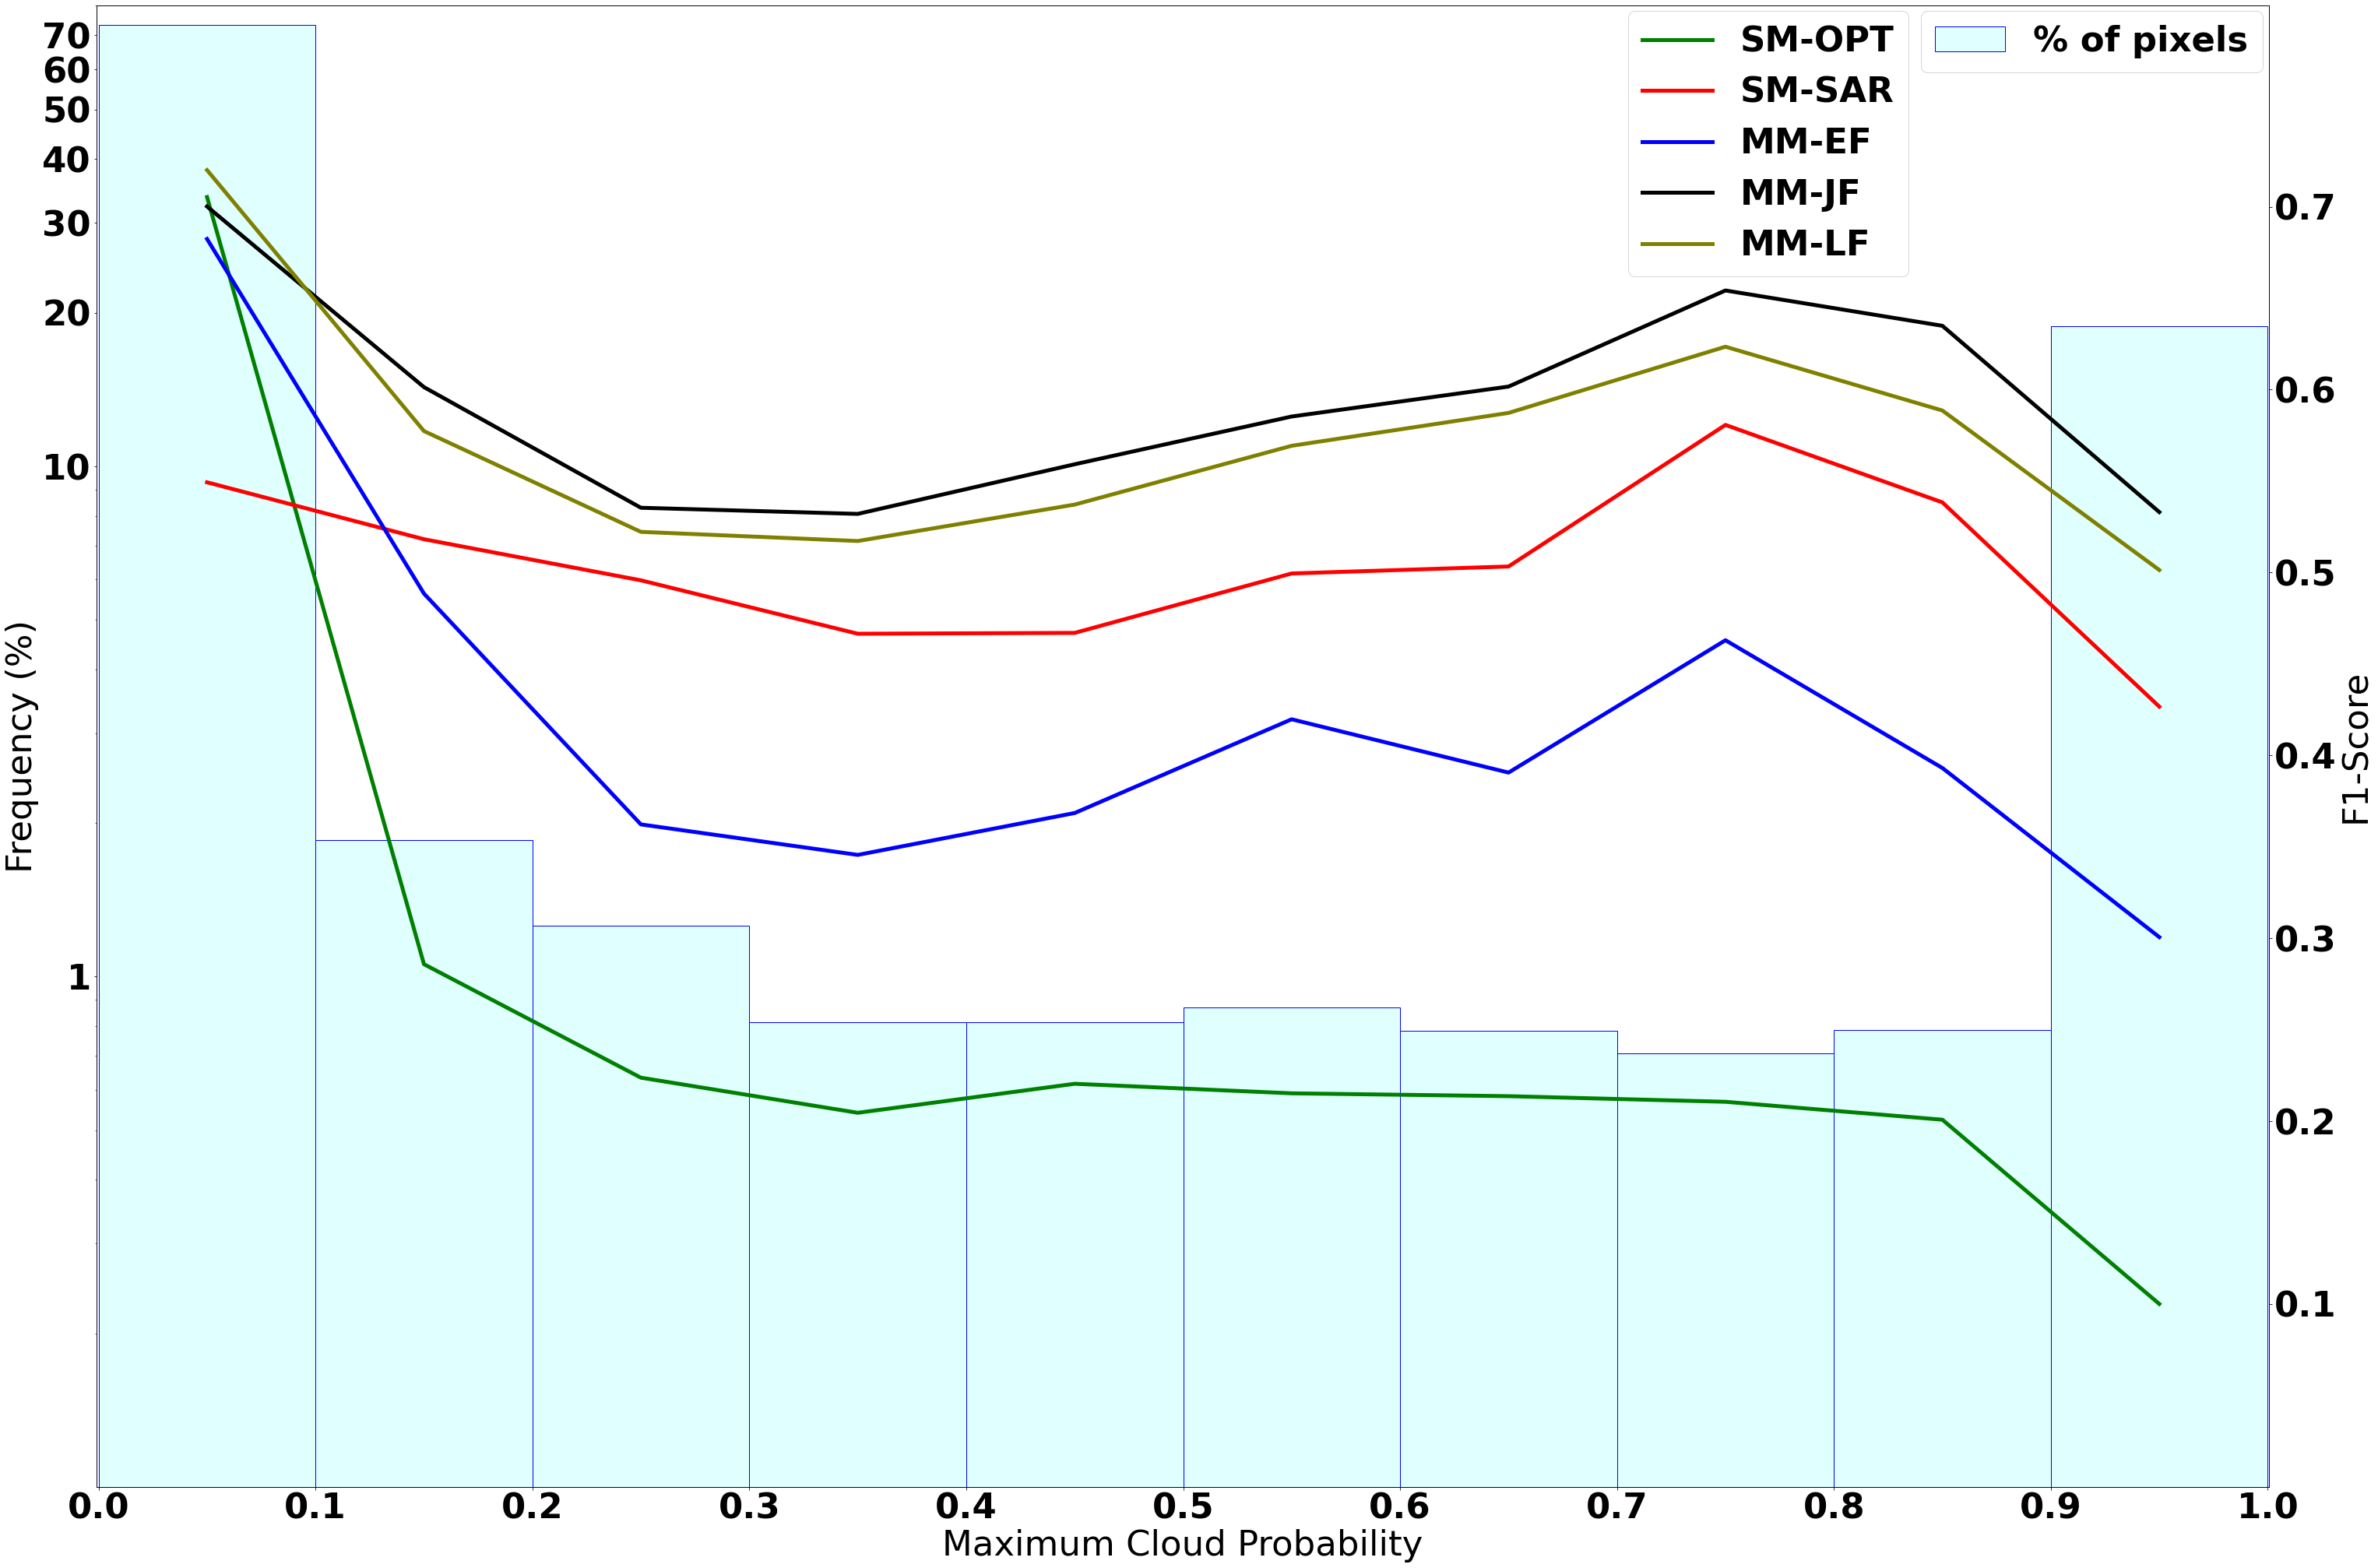

In [24]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 45}
lw = 5

plt.rc('font', **font)

fig, ax1 = plt.subplots()
fig.set_figheight(35)
fig.set_figwidth(50)
ax2 = ax1.twinx()
ax1.bar(
    opt_h[1][:-1], 
    opt_cmap_hist*100,
    width=1/(n_bins),
    color='lightcyan',
    edgecolor='blue',
    align='edge')
ax1.set_xlabel('Maximum Cloud Probability')
ax1.set_ylabel('Frequency (%)')
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    opt_bins_f1score,
    color = 'g',
    linewidth = lw)
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    sar_bins_f1score,
    color = 'r',
    linewidth = lw)
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    ef_bins_f1score,
    color = 'b',
    linewidth = lw)
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    jf_bins_f1score,
    color = 'k',
    linewidth = lw)
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    lf_bins_f1score,
    color = 'olive',
    linewidth = lw)
    
ax2.set_ylabel('F1-Score')
ax1.set_xlim([-0.001,1.0005])
ax1.set_ylim([0.1,80])
ax2.set_ylim([0,0.81])

ax1.set_yscale('log')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax1.get_yaxis().get_major_formatter().labelOnlyBase = False


ax1.legend(['% of pixels'], loc=[0.84,0.955])
ax2.legend([
    'SM-OPT',
    'SM-SAR',
    'MM-EF',
    'MM-JF',
    'MM-LF'
    ], loc=[0.705,0.817])
ax1.set_yticks([1,  10, 20, 30, 40, 50, 60, 70])
ax1.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax2.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

(0.5, 0.8)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


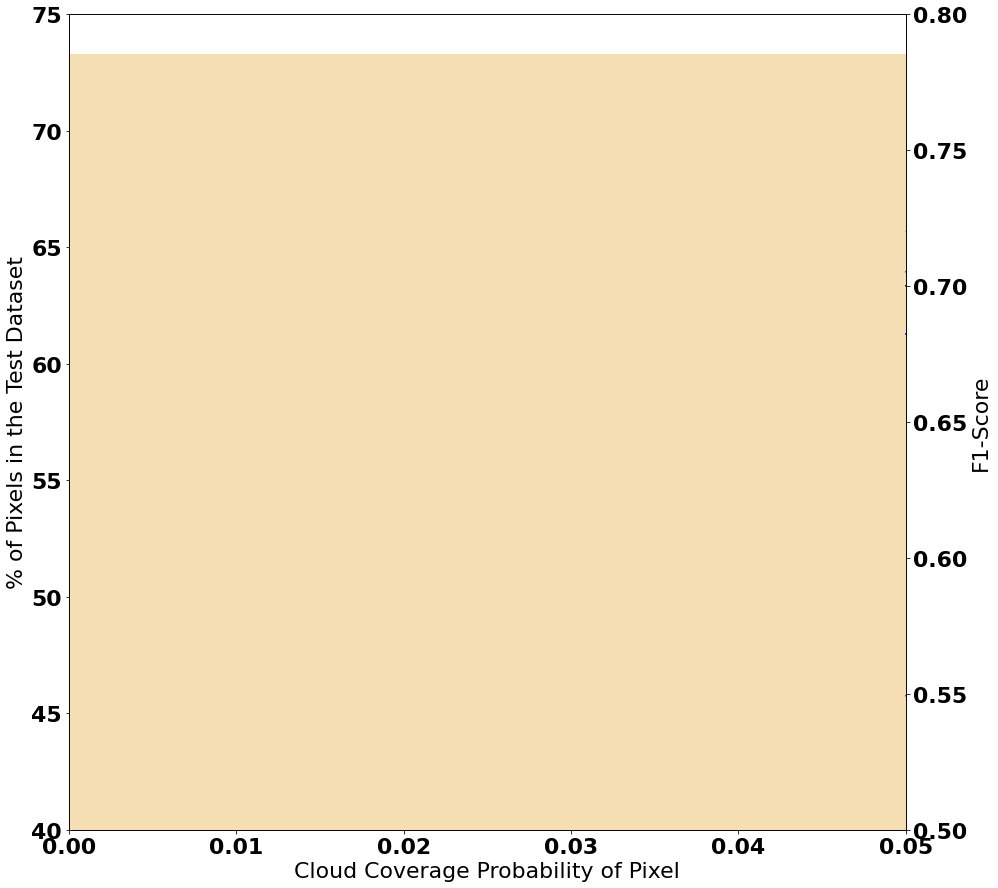

In [25]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

fig, ax1 = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
ax2 = ax1.twinx()
ax1.bar(
    opt_h[1][:-1], 
    opt_cmap_hist*100,
    width=1/(n_bins),
    color='wheat',
    align='edge')
ax1.set_xlabel('Cloud Coverage Probability of Pixel')
ax1.set_ylabel('% of Pixels in the Test Dataset')
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    opt_bins_f1score,
    color = 'g')
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    sar_bins_f1score,
    color = 'r')
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    ef_bins_f1score,
    color = 'b')
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    jf_bins_f1score,
    color = 'k')
ax2.plot(
    opt_h[1][:-1]+1/(2*n_bins), 
    lf_bins_f1score,
    color = 'y')
ax2.set_ylabel('F1-Score')
ax1.set_xlim([0,0.05])
ax1.set_ylim([40,75])
ax2.set_ylim([0.5,0.8])
